# Variational Autoencoder using ratio matching

This is a Tensorflow implementation of a Variational-EM algorithm using ratio matching. It is adapted from the work Variational Autoencoder (VAE) on MNIST data, based on *Auto-Encoding Variational Bayes* (Kingma and Welling 2014).

The MNIST dataset, distributed by Yann Lecun's [THE MNIST DATABASE of handwritten digits](http://yann.lecun.com/exdb/mnist/) website, consists of pair "handwritten digit image" and "label". The image is a gray scale image with 28 x 28 pixels. Pixel values range from 0 (black) to 255 (white), scaled in the [0, 1] interval. The label is the actual digit, ranging from 0 to 9, the image represents.

The original notebook was composed by [Jan Hendrik Metzen](https://jmetzen.github.io/2015-11-27/vae.html). 

In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)

### Load MNIST data in a format suited for Tensorflow

The 'input_data' script is available at: https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/examples/tutorials/mnist/input_data.py

In [2]:
import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Code for Xavier initialization of network weights

Why Xavier initialization:
https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow

Xavier initialization in Tensorflow:
https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow

In [3]:
def xavier_init(fan_in, fan_out, constant = 1): 
    
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval = low, maxval = high, 
                             dtype = tf.float32)

### Code for algorithm implementation

In [4]:
class VariationalAutoencoder(object):
    
    def __init__(self, network_architecture, 
                 learning_rate = 0.0001, batch_size = 100):
        self.network_architecture = network_architecture
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # Create a placeholder for input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        # Create recognition and generator networks (a.k.a the encoder and decoder)
        self._create_network()
        
        # Define the loss function and the corresponding optimizer
        self._create_loss_optimizer()
        
        # Initialize Tensorflow variables
        init = tf.global_variables_initializer()

        # Launch session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
    
    
    def _create_network(self):
        
        # Initialize network weights and biases
        network_weights = self._initialize_weights(**self.network_architecture)
        
        n_z = self.network_architecture["n_z"]
        
        # Recognition network (Encoder) determines the mean and (log) variance 
        # of the Gaussian distribution in latent space
        # (x -> z_mu, z_sigma -> z)
        self.z_mean, self.z_log_sigma_sq = self._recognition_network(network_weights["weights_recog"], network_weights["biases_recog"])

        # Draw a sample from the Gaussian posterior WITH the reparameterization trick
        
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, dtype = tf.float32)
        self.z = tf.add(self.z_mean, tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

        # Draw a sample from the Gaussian posterior WITHOUT the reparameterization trick
        #self.z = tf.random_normal((self.batch_size, n_z), self.z_mean, tf.sqrt(tf.exp(self.z_log_sigma_sq)), dtype = tf.float32)
        
        self.z1 = tf.random_normal((self.batch_size, n_z), self.z_mean, tf.sqrt(tf.exp(self.z_log_sigma_sq)), dtype = tf.float32)
        
        self.z2 = tf.random_normal((self.batch_size, n_z), self.z_mean, tf.sqrt(tf.exp(self.z_log_sigma_sq)), dtype = tf.float32)
        
        # Generator network (Decoder) determines the mean of the Bernoulli 
        # distribution of the reconstructed input
        # (z -> x_hat)
        self.y, self.y1, self.y2 = self._generator_network(network_weights["weights_gener"], network_weights["biases_gener"])
            
            
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_gener_1,
                            n_input, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'W3': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'W4': tf.Variable(xavier_init(n_hidden_recog_1, n_z)),
            'W5': tf.Variable(xavier_init(n_hidden_recog_1, n_z))}
        all_weights['biases_recog'] = {
            'b3': tf.Variable(tf.zeros([n_hidden_recog_1], dtype = tf.float32)),
            'b4': tf.Variable(tf.zeros([n_z], dtype = tf.float32)),
            'b5': tf.Variable(tf.zeros([n_z], dtype = tf.float32))}
        all_weights['weights_gener'] = {
            'W1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'W2': tf.Variable(xavier_init(n_hidden_gener_1, n_input))}
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype = tf.float32)),
            'b2': tf.Variable(tf.zeros([n_input], dtype = tf.float32))}
        return all_weights
            
        
    def _recognition_network(self, weights, biases): 

        h = tf.nn.tanh(tf.add(tf.matmul(self.x, weights['W3']), biases['b3'])) 
        z_mean = tf.add(tf.matmul(h, weights['W4']), biases['b4'])
        z_log_sigma_sq = tf.add(tf.matmul(h, weights['W5']), biases['b5'])
        return (z_mean, z_log_sigma_sq)

    
    def _generator_network(self, weights, biases): 
        
        W1 = tf.stop_gradient(weights['W1'])
        W2 = tf.stop_gradient(weights['W2'])
        b1 = tf.stop_gradient(biases['b1'])
        b2 = tf.stop_gradient(biases['b2'])
        
        layer_y = tf.nn.tanh(tf.add(tf.matmul(self.z, weights['W1']), biases['b1'])) 
        y = tf.nn.sigmoid(tf.add(tf.matmul(layer_y, weights['W2']), biases['b2']))
                
        layer_y1 = tf.nn.tanh(tf.add(tf.matmul(self.z1, W1), b1)) 
        y1 = tf.nn.sigmoid(tf.add(tf.matmul(layer_y1, W2), b2))
                  
        layer_y2 = tf.nn.tanh(tf.add(tf.matmul(self.z2, W1), b1)) 
        y2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_y2, W2), b2))
        
        return (y, y1, y2)
           
        
    def _create_loss_optimizer(self):
        
        n_z = self.network_architecture["n_z"]
        
        # 1. The reconstruction loss  
        reconstr_loss = -tf.reduce_sum(self.x * tf.log(1e-10 + self.y) + (1 - self.x) * tf.log(1e-10 + 1 - self.y), 1)
         
        # 2. The latent loss
        log_lk_1 = tf.reduce_sum(self.x * tf.log(1e-10 + self.y1) + (1 - self.x) * tf.log(1e-10 + 1 - self.y1), 1)
        log_lk_2 = tf.reduce_sum(self.x * tf.log(1e-10 + self.y2) + (1 - self.x) * tf.log(1e-10 + 1 - self.y2), 1)
        
        # Add log priors
        prior_dist = tf.contrib.distributions.MultivariateNormalDiag(tf.constant(0.0, shape = [n_z]), tf.constant(1.0, shape = [n_z]))
        log_prior_1 = tf.log(1e-10 + prior_dist.prob(self.z1))
        log_prior_2 = tf.log(1e-10 + prior_dist.prob(self.z2))
        
        # Obtain log posterior samples
        post_dist = tf.contrib.distributions.MultivariateNormalDiag(self.z_mean, tf.exp(self.z_log_sigma_sq))
        log_post_1 = tf.log(1e-10 + post_dist.prob(self.z1))
        log_post_2 = tf.log(1e-10 + post_dist.prob(self.z2))
        
        rm_loss = tf.square(log_lk_1 - log_lk_2 + log_prior_1 - log_prior_2 - log_post_1 + log_post_2)
        penalty = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq - tf.square(self.z_mean) - tf.exp(self.z_log_sigma_sq), 1)
        latent_loss = rm_loss + tf.square(penalty)
        
        # Optimize based on the average loss of mini-batch
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.learning_rate).minimize(self.cost)
        
        
    def partial_fit(self, X):
        # Train the model based on mini-batch of input data 
        # and return the cost of mini-batch.
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x: X})
        return cost
    
    
    def transform(self, X):
        # Transform data by mapping it into the latent space.
        return self.sess.run(self.z_mean, feed_dict = {self.x: X})
    
    
    def generate(self, z_mu = None):
        # Generate data by sampling from the latent space.
        # If z_mu is not None, data for this point in the latent space is
        # generated. Otherwise, z_mu is drawn from prior in the latent space.        
        if z_mu is None:
            z_mu = np.random.normal(size = self.network_architecture["n_z"])
            
        return self.sess.run(self.y, feed_dict = {self.z: z_mu})
    
    
    def reconstruct(self, X):
        # Reconstruct given data using the trained VAE.
        return self.sess.run(self.y, feed_dict = {self.x: X})

### Code for training using mini-batches

In [5]:
def train(network_architecture, learning_rate = 0.0001,
          batch_size = 100, training_epochs = 10, display_step = 5):
    vae = VariationalAutoencoder(network_architecture, 
                                 learning_rate = learning_rate, 
                                 batch_size = batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)

            # Fit training using batch data
            cost = vae.partial_fit(batch_xs)
            
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), 
                  "cost=", "{:.9f}".format(avg_cost))
            
    return vae

### Training on MNIST data

In [6]:
network_architecture = \
    dict(n_hidden_recog_1 = 500, # 1st layer encoder neurons
         n_hidden_gener_1 = 500, # 1st layer decoder neurons
         n_input = 784, # MNIST data input (28*28 pixels)
         n_z = 20) # Dimensionality of latent space

vae = train(network_architecture, training_epochs = 50)

('Epoch:', '0001', 'cost=', '578.840596369')
('Epoch:', '0006', 'cost=', '374.530110529')
('Epoch:', '0011', 'cost=', '317.738880282')
('Epoch:', '0016', 'cost=', '328.463318149')
('Epoch:', '0021', 'cost=', '318.941806363')
('Epoch:', '0026', 'cost=', '311.690269720')
('Epoch:', '0031', 'cost=', '307.292607588')
('Epoch:', '0036', 'cost=', '306.786388883')
('Epoch:', '0041', 'cost=', '307.338190252')
('Epoch:', '0046', 'cost=', '308.730940330')


### Reconstruction of the input data

On the left are MNIST data samples, and on the right are their reconstructions by our trained VAE.

In our VAE, first, the encoder $q_{\phi}(z \vert x)$ maps data $(x)$ onto a normal distribution in the latent space. Then the decoder $p_{\theta}(x \vert z)$ maps points in the latent spaze onto a Bernoulli distribution in the data space. The result of this latter mapping $(\hat{x})$ is what we mean by reconstruction. In short, reconstruction $(\hat{x})$ is what comes out when we feed data $(x)$ into our trained VAE.

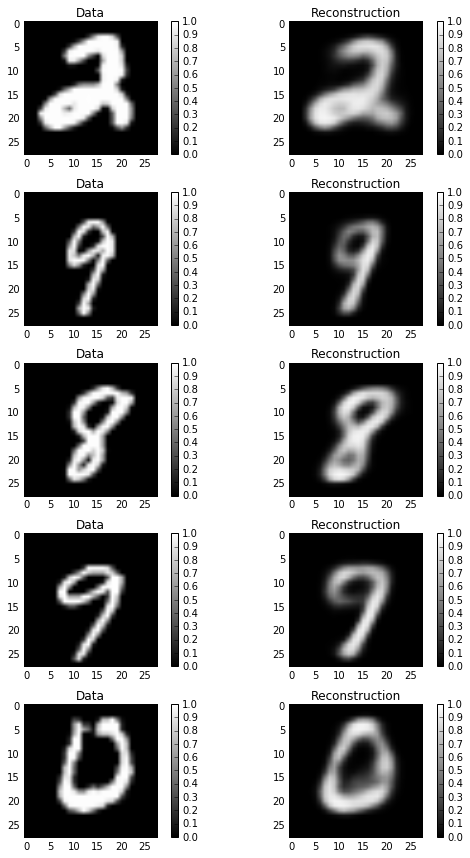

In [7]:
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = vae.reconstruct(x_sample)

plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin = 0, vmax = 1, cmap = "gray")
    plt.title("Data")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin = 0, vmax = 1, cmap = "gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

### Generating new data from the trained algorithm

To generate synthetic data, we just need to sample noise vectors from $N(0, 1)$ and feed it through the generator network (decoder). 


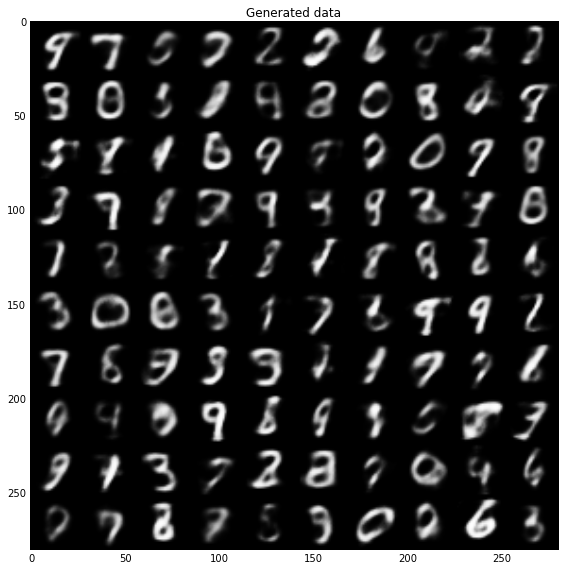

In [8]:
new_z = np.random.normal(size = [100, 20]) # [batch size, dimensionality of latent space]
new_data = vae.generate(new_z)

n = np.sqrt(vae.batch_size).astype(np.int32)
I_generated = np.empty((28*n, 28*n))
for i in range(n):
    for j in range(n):
        I_generated[i*28:(i+1)*28, j*28:(j+1)*28] = new_data[i*n+j, :].reshape(28, 28)

plt.figure(figsize = (8, 8))
plt.title("Generated data")
plt.imshow(I_generated, cmap = 'gray')
plt.tight_layout()